### Replicates the 3 state model case with Refactored Code

In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables
x0 = VariableVector(cAl2O3=3.5, uAl2O3=0.5, ACD= 2.9193)
x0.dictionary

{'cAl2O3': 0, 'uAl2O3': 1, 'ACD': 2}

In [8]:
# Create Input Vector Variables
u0 = VariableVector(I=126000.0, g=0.0, B=0.0)
u0.dictionary

{'I': 0, 'g': 1, 'B': 2}

In [9]:
# Create Measurement Vector Variables
z0 = VariableVector(Vcell=4.465858)
z0.dictionary

{'Vcell': 0}

In [10]:
# Define the F matrix for 3 state model with first order dependency on dT
F = ControlMatrix(3, 3, 1)
# Identity matrix for the terms independent of dT
F.set_array_layer(0, np.identity(3, dtype=float))

True

In [11]:
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, bbcell.kdiss, 0.0], [0.0, -bbcell.kdiss, 0.0], [0.0, 0.0, 0.0]]))

True

In [12]:
F.array_display

array([[[ 1.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  1.   ]],

       [[ 0.   ,  0.002,  0.   ],
        [ 0.   , -0.002,  0.   ],
        [ 0.   ,  0.   ,  0.   ]]])

In [13]:
F.array_eval(5)

array([[1.  , 0.01, 0.  ],
       [0.  , 0.99, 0.  ],
       [0.  , 0.  , 1.  ]])

In [14]:
# Define G with simple 3 terms, diagonal "dT"
G = ControlMatrix(3, 3, 1)
G.set_array_layer(0, np.zeros((3,3)))
G.set_array_layer(1, np.identity(3, dtype=float))

True

In [15]:
G.array_eval(5)

array([[5., 0., 0.],
       [0., 5., 0.],
       [0., 0., 5.]])

In [16]:
B = ControlMatrix(3, 3, 1)
B.set_array_layer(0, np.array([[0.0, 100*(1-bbcell.r)/bbcell.m, 0.0], [0.0, 100*bbcell.r/bbcell.m, 0.0], [0.0, 0.0, 1.0]]))
B.set_array_layer(1, np.array([[-gamma/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [bbcell.alpha, 0.0, 0.0]]))

True

In [17]:
B.array_eval(5)

array([[-4.62315993e-08,  2.22222222e-02,  0.00000000e+00],
       [ 0.00000000e+00,  3.33333333e-02,  0.00000000e+00],
       [-1.64690382e-10,  0.00000000e+00,  1.00000000e+00]])

In [18]:
# Define the UKF noise standard deviations
q1dstd = 0.0002    # alumina concentration variation
q1ustd = 0.0002    # undisolved alumina concentration variation
q2std = 0.0000001  # acd varation needs to be much lower
Q = ControlMatrix(3, 3, 0)
Q.set_array_layer(0, np.array([[q1dstd**2, 0.0, 0.0], [0.0, q1ustd**2, 0.0], [0.0, 0.0, q2std**2]]))
Q.array_display

array([[[4.e-08, 0.e+00, 0.e+00],
        [0.e+00, 4.e-08, 0.e+00],
        [0.e+00, 0.e+00, 1.e-14]]])

In [19]:
# Define the measurement standard deviations
rstd = 0.0010      # measurement variation (volts)
R = ControlMatrix(1, 1, 0)
R.set_array_layer(0, np.array([[rstd**2]]))
R.array_display

array([[[1.e-06]]])

In [20]:
from Refactor.UKFClass import DiscreteModel

In [21]:
alumina3state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)

In [22]:
alumina3state.defined

True

In [23]:
alumina3state.x0.vector

array([[3.5   ],
       [0.5   ],
       [2.9193]])

In [24]:
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack

In [25]:
UKF3state = UKF(alumina3state, bbcell, x0, 5)

In [26]:
UKF3state.initialised

True

In [27]:
UKF3state.update_timestep(5)

False

In [28]:
UKF3state.Qm

array([[1.0e-06, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.0e-06, 0.0e+00],
       [0.0e+00, 0.0e+00, 2.5e-13]])

In [29]:
UKF3state.Rm

array([[1.e-06]])

In [30]:
UKF3state.dT

5

In [31]:
# predict the state for next timestep using the current input and state vectors
UKF3state.predict_state(u0, 5)

True

In [32]:
UKF3state.uk.vector

array([[126000.],
       [     0.],
       [     0.]])

In [33]:
UKF3state.Ppred

array([[1.0101e-04, 9.9000e-07, 0.0000e+00],
       [9.9000e-07, 9.9010e-05, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 2.5250e-11]])

In [34]:
UKF3state.predictionflag

True

In [35]:
# the next timestep prediction
UKF3state.xpred.vector

array([[3.49917482],
       [0.495     ],
       [2.91927925]])

In [36]:
# calling the UKF method to see the UKF samples generated around xpred
UKF3state.ukf_gen_samples()

(True,
 array([[[3.49917482],
         [0.495     ],
         [2.91927925]],
 
        [[3.51927556],
         [0.49519701],
         [2.91927925]],
 
        [[3.47907407],
         [0.49480299],
         [2.91927925]],
 
        [[3.49917482],
         [0.51489978],
         [2.91927925]],
 
        [[3.49917482],
         [0.47510022],
         [2.91927925]],
 
        [[3.49917482],
         [0.495     ],
         [2.9192893 ]],
 
        [[3.49917482],
         [0.495     ],
         [2.9192692 ]]]),
 array([[[0.25 ]],
 
        [[0.125]],
 
        [[0.125]],
 
        [[0.125]],
 
        [[0.125]],
 
        [[0.125]],
 
        [[0.125]]]))

In [37]:
# generate a new observation
z1 = clone_vector(z0)
z1.setvariable('Vcell', 4.47010343)
z1.vector

array([[4.47010343]])

In [38]:
# perform and update step with the new observation
UKF3state.update_state(z1)

True

In [39]:
UKF3state.xpredsamples

array([[[3.49917482],
        [0.495     ],
        [2.91927925]],

       [[3.51927556],
        [0.49519701],
        [2.91927925]],

       [[3.47907407],
        [0.49480299],
        [2.91927925]],

       [[3.49917482],
        [0.51489978],
        [2.91927925]],

       [[3.49917482],
        [0.47510022],
        [2.91927925]],

       [[3.49917482],
        [0.495     ],
        [2.9192893 ]],

       [[3.49917482],
        [0.495     ],
        [2.9192692 ]]])

In [40]:
UKF3state.zpredsamples

array([[[4.46784157]],

       [[4.467502  ]],

       [[4.46819449]],

       [[4.46784157]],

       [[4.46784157]],

       [[4.46784646]],

       [[4.46783668]]])

In [41]:
UKF3state.innov

array([[0.00226019]])

In [42]:
UKF3state.zbar

array([[4.46784324]])

In [43]:
UKF3state.Pzz

array([[2.99857831e-08]])

In [44]:
UKF3state.xest.vector

array([[3.4953567 ],
       [0.49496258],
       [2.91927928]])

In [45]:
UKF3state.innov_cov

array([[1.02998578e-06]])

In [46]:
UKF3state.Pxz

array([[-1.73994725e-06],
       [-1.70532401e-08],
       [ 1.22857715e-11]])

In [47]:
UKF3state.Kgain

array([[-1.68929249e+00],
       [-1.65567723e-02],
       [ 1.19280981e-05]])

In [48]:
UKF3state.zk.vector

array([[4.47010343]])

In [49]:
UKF3state.Pest

array([[9.80707202e-05, 9.61192090e-07, 2.07542615e-11],
       [9.61192090e-07, 9.90097177e-05, 2.03412720e-13],
       [2.07542615e-11, 2.03412720e-13, 2.52498535e-11]])

In [50]:
UKF3state.determinant

2.451515527411112e-19

In [51]:
UKF3state.condition_num

3944971.9987781206

In [52]:
UKF3state.predictionflag

False

In [53]:
from Refactor.Simulation import sim_nofeeding, plot_xsim, sim_observation, plot_zsim

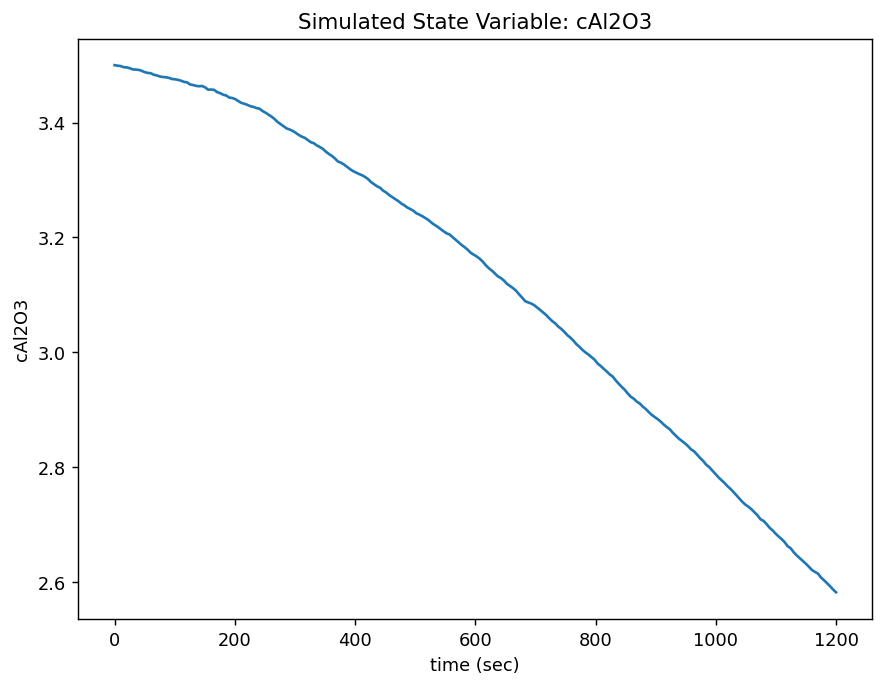

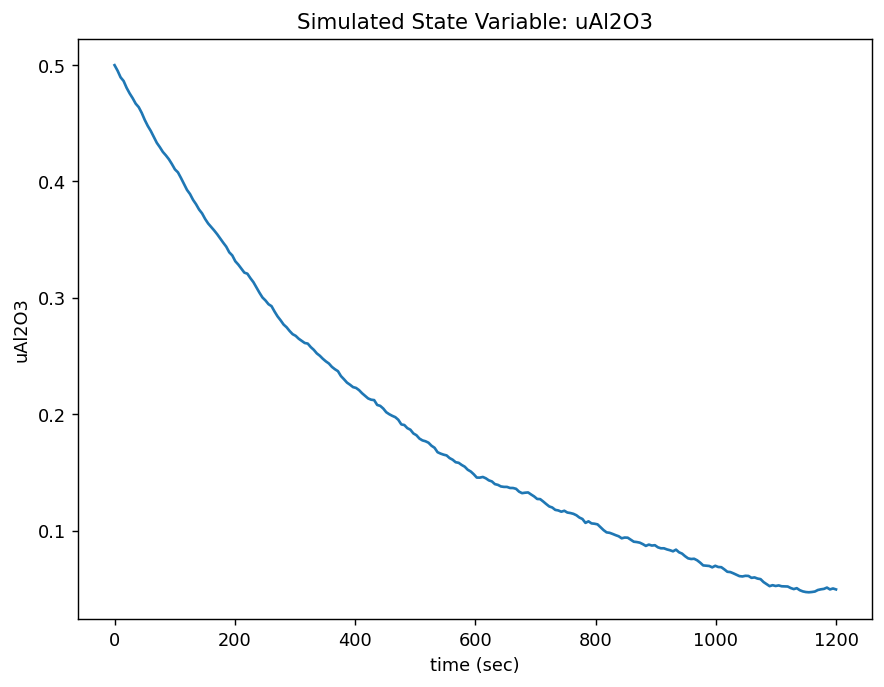

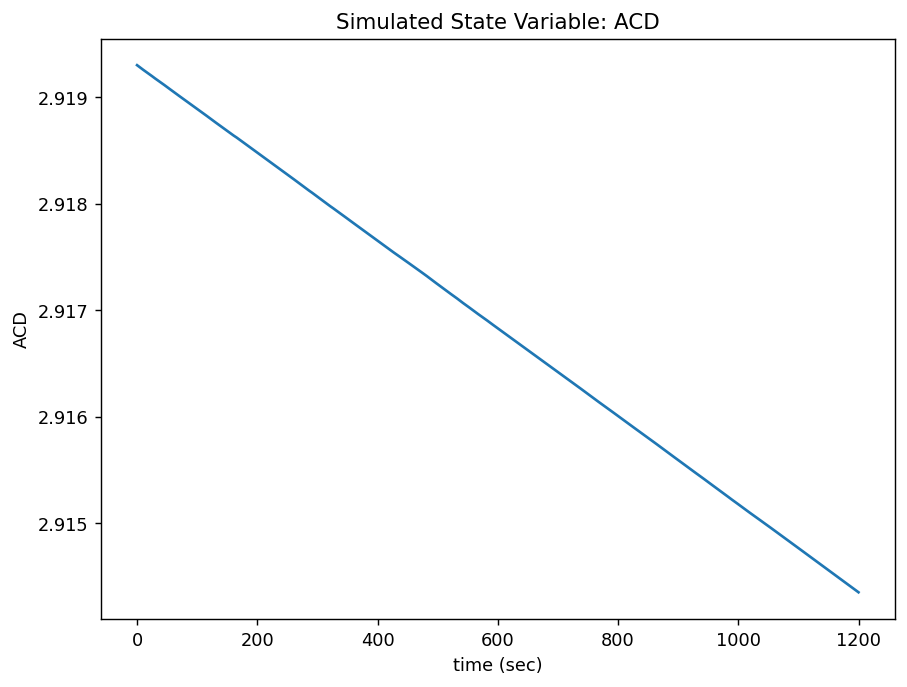

In [54]:
x, u = sim_nofeed(5, 240, bbcell, alumina3state, u0, x0, Istd=50, plotresult=True)

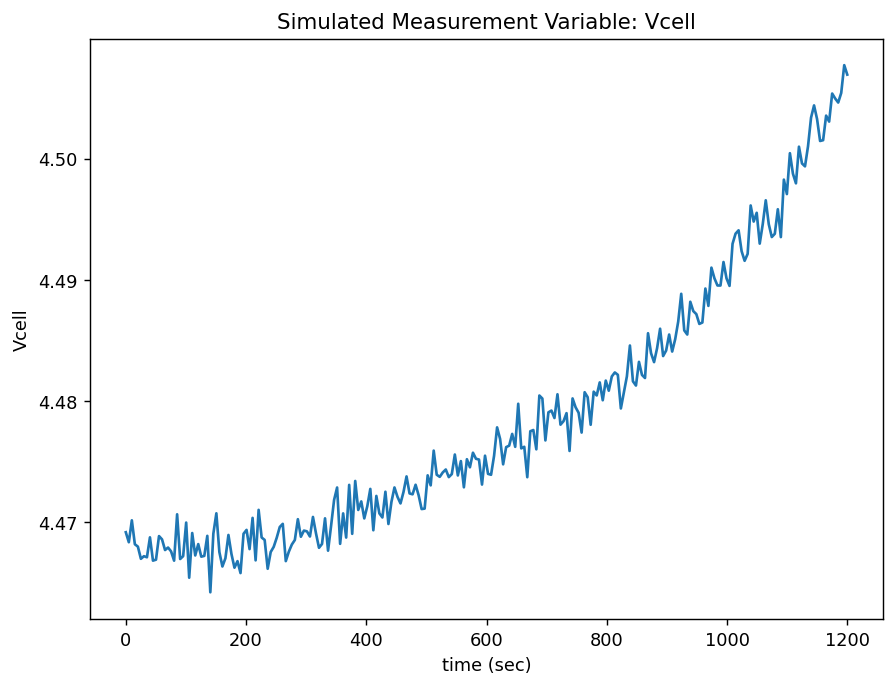

In [55]:
z = sim_observation(5, x, u, bbcell, alumina3state, plotresult=True)

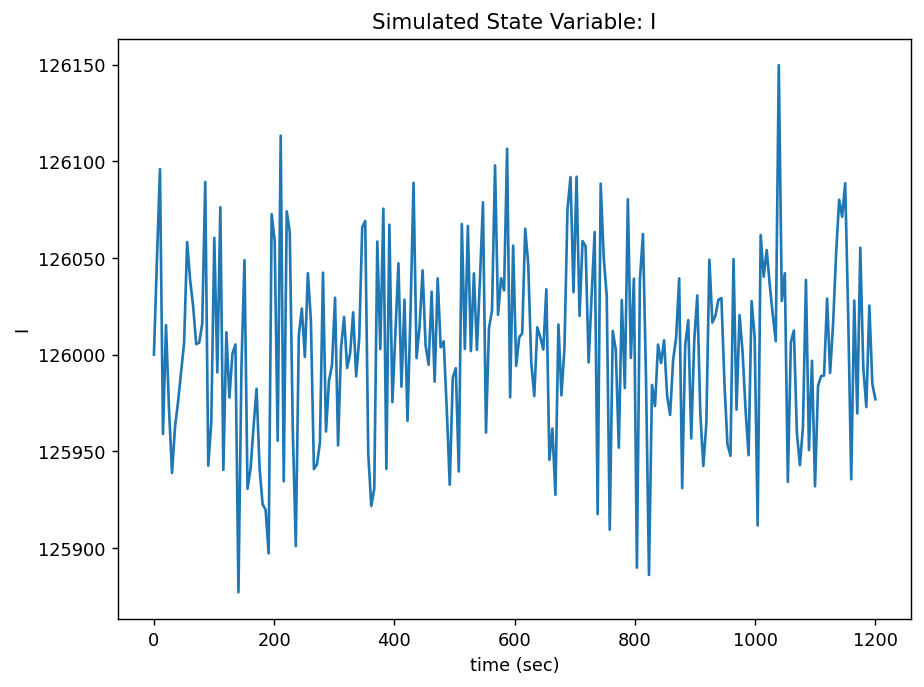

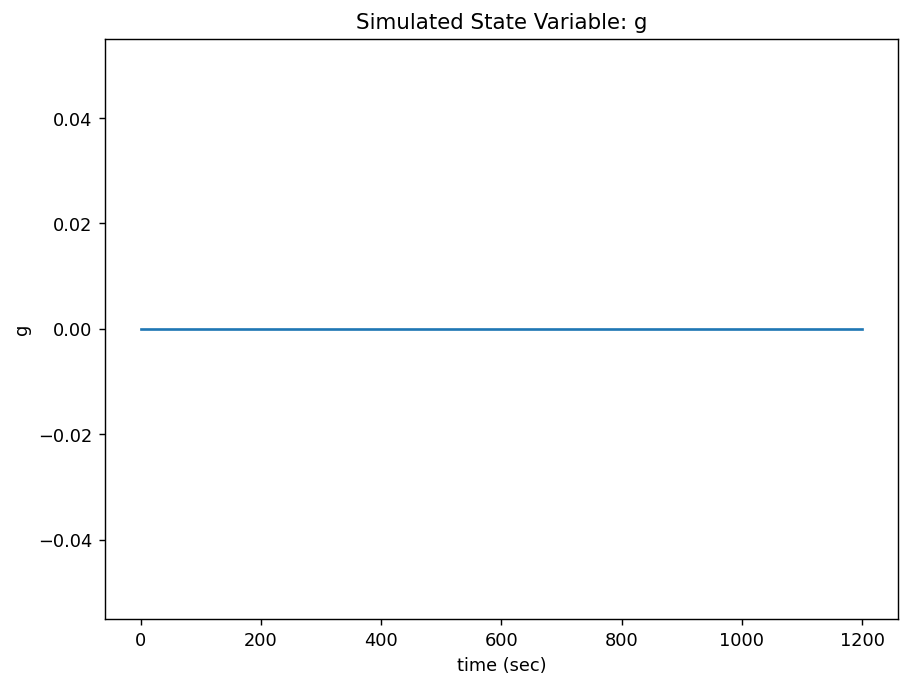

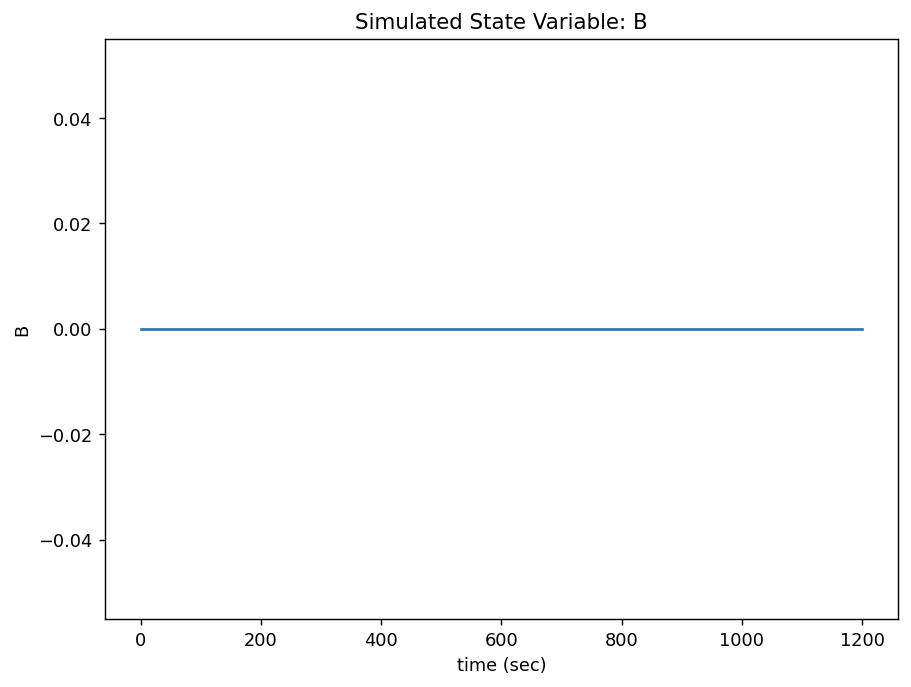

In [56]:
# note the labelling on these charts says "state" but should read "input"
plot_xsim(list(u0.dictionary.keys()), u, 5)